# Implementation and empirical analysis of Karger's algorithm on graphs

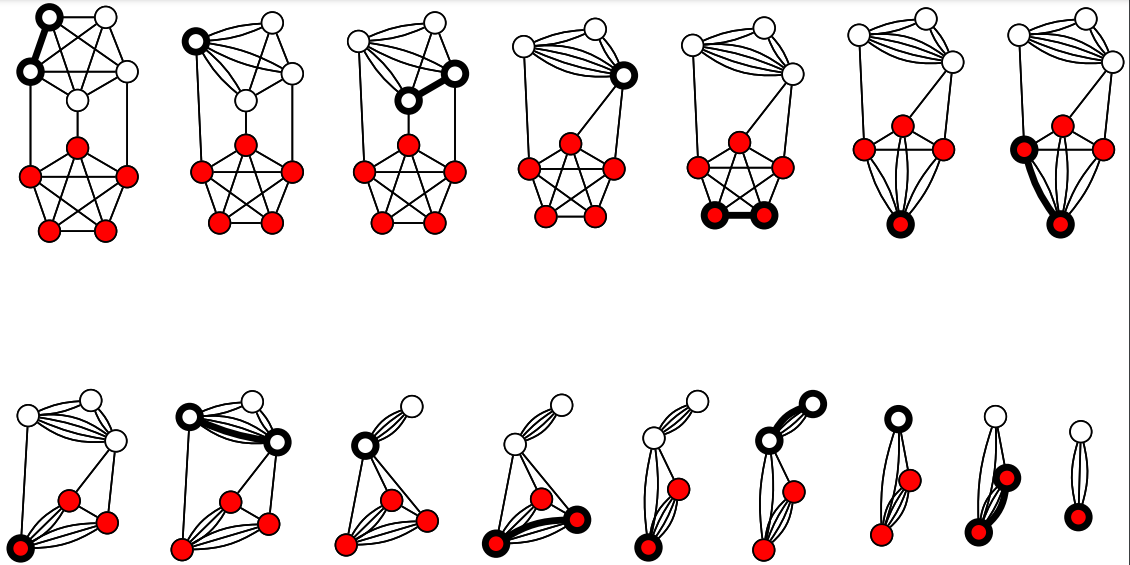

## What is this problem about?

When you have a graph and you need to separate this graph on two groups cutting the fewest possible edges(**minimum cut**) as a representation of the image above with the Red and White groups. But you might argue that this instance is easy to see which is the **minimum cut** and really is, but I'll' show some hard ones.

We are gonna see the Karger's Algorithm(*It was invented by David Karger and first published in 1993*) that is a randomized algorithm (different of randomic which everything is a flip of coin) performance comparing to a fully randomic algorithm.

The main idea is: get a randomic edge and contract it (get the two nodes that form this edge, merge them and make a 'SuperNode' **KEEPING THE CONNECTIONS OF BOTH WITH THE OTHERS NODES**), the steps of this algorithm is represented on the image above. At the end of all steps will rest two nodes and a group of edges, this group represent the **minimun cut** and the 2 remaining SuperNodes are que representations of each group.

## General Use

In [2]:
class Graph:

    def __init__(self, instance=None):
        self.matrix, self.adj_lists, self.edges, self.n_vertices = self.__read_instance(instance)

    @staticmethod
    def __read_instance(instance):
        """
        It reads the instance file and returns the adjacency matrix, adjacency 
        lists, edges, and number of vertices
        
        :param instance: the path to the instance file
        :return: The adjacency matrix, adjacency lists, edges, and number of 
        vertices.
        """
        file = open(instance, 'r')
        n_vertices = int(file.readline())
        matrix = []
        for _ in range(n_vertices):
            line = file.readline()
            matrix.append([int(i) for i in line.split()])
        file.close()
        
        adj_lists = []
        for i in range(n_vertices):
            n_adj = [i + 1 for i, a in enumerate(matrix[i]) if a == 1]
            adj_lists.append(n_adj)

        edges = []
        for i in range(n_vertices):
            j = i + 1
            while j < n_vertices:
                if matrix[i][j]:
                    edges.append([i + 1, j + 1])
                j += 1

        return matrix, adj_lists, edges, n_vertices

An instance of a graph could be like this: 

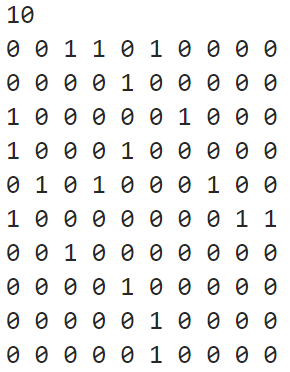

## Instances of Graphs used
We have two directories, "in" and "out". in is the instances with the first number representing how many nodes is that instance and out is the answer of that instance with the first number being the size of minimum cut and the last two lines are an example of the two groups (a graph could have several minimum cuts but their size must be the same)
You could find them below:
* [in](https://github.com/davirpp/Karger_algorithm/tree/main/in)
* [out](https://github.com/davirpp/Karger_algorithm/tree/main/out)


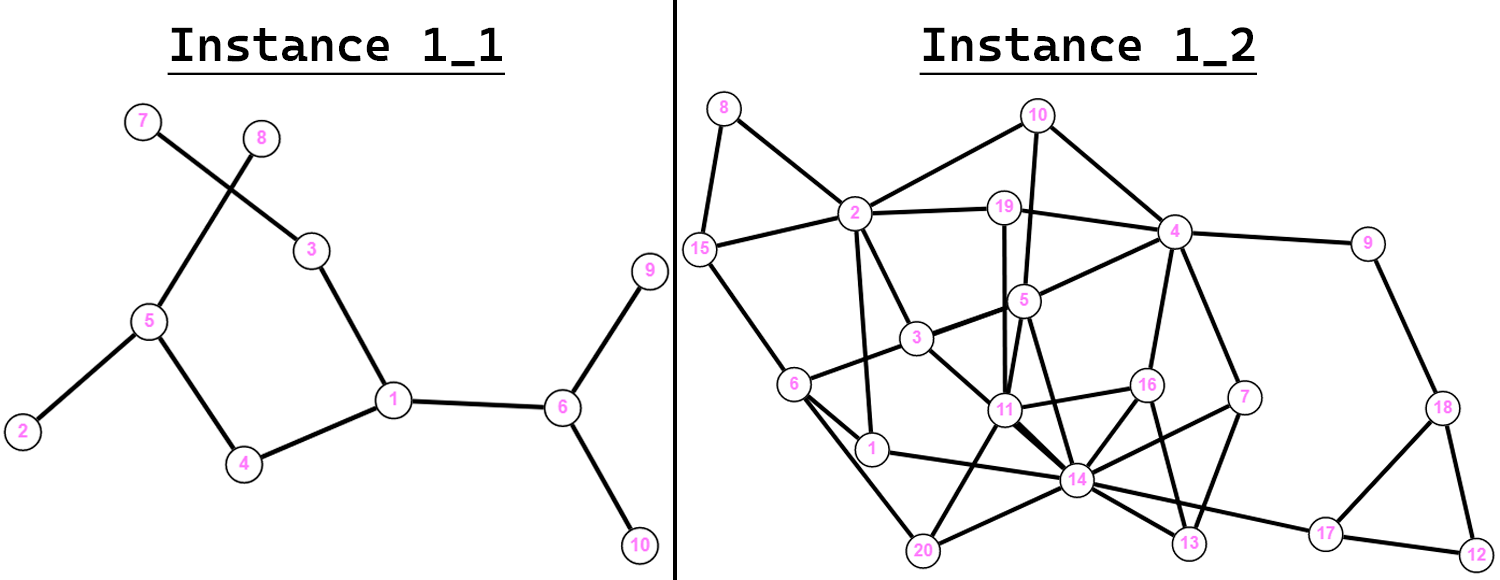

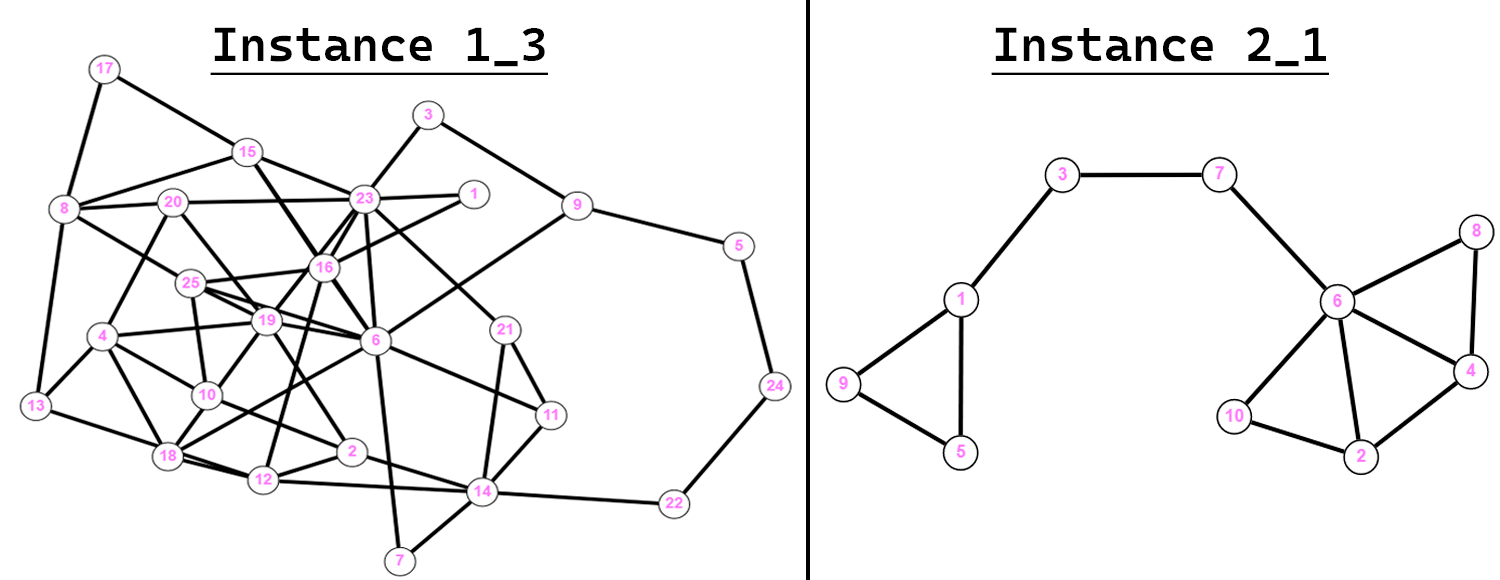

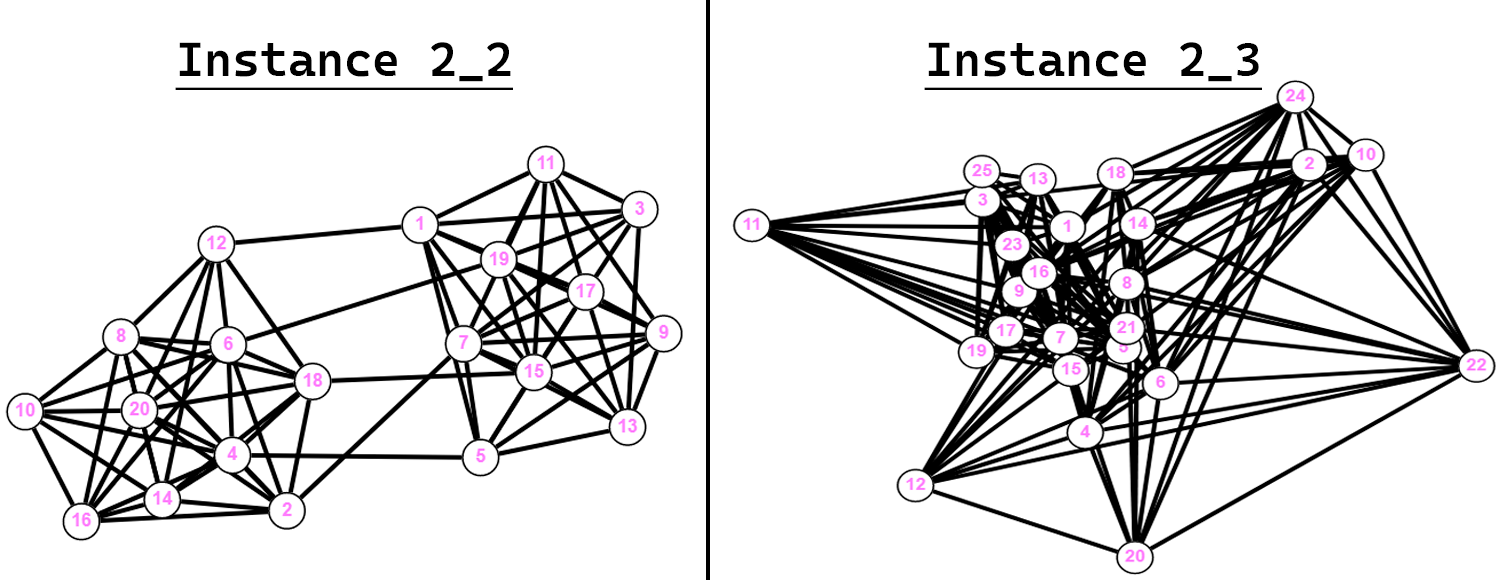

## Karger's Algorithm

In [1]:
import contextlib
from itertools import product
import numpy.random as nrd

In [4]:
def not_best_prob(N: int, n: int) -> float:
    """
    The probability of not getting the best answer
    
    
    :param N: number of times to run the Karger's algorithm
    :type N: int
    :param n: number of vertices in the graph
    :type n: int
    :return: The probability that the best solution is not found.
    """
    return (1 - (2/(n**2 - n)))**N


class SuperGraph:
    def __init__(self, graph):
        self.edges = graph.edges.copy()
        self.aux_edges = []
        self.vertex = list(range(1, graph.n_vertices + 1))
        self.n_vertex = graph.n_vertices
        self.SN = {}

    def contract(self, edge_idx: int) -> None:
        """
        It takes an edge index as input, and contracts it to one supernode 
        keeping all conections.
        
        :param edge_idx: the index of the edge to be contracted
        :type edge_idx: int
        """
        flag = False
        if not 0 <= edge_idx <= len(self.edges):
            raise ValueError('Edge index out of range')

        # Pair of vertices to be contracted
        contraction = (self.edges[edge_idx][0], self.edges[edge_idx][1])
        # Removing the vertices from the list of vertices
        for i in range(2): #len(contraction)
            self.vertex.remove(contraction[i])

        # Adding the new supernode to the list of vertices
        self.vertex.append(self.n_vertex + 1)
        self.n_vertex += 1
        self.SN[self.n_vertex] = [*contraction]

        # Checking if the edge to be contracted is in the list of SuperNodes
        # If it is, it will be removed and the new supernode will be added
        for i in range(2): #len(contraction)
            if contraction[i] in self.SN.keys():
                self.SN[self.n_vertex].extend(self.SN[contraction[i]])
                self.SN[self.n_vertex].remove(contraction[i])
                del self.SN[contraction[i]]

        for i, x in enumerate(self.edges):
            if x == list(contraction) or x[::-1] == list(contraction):
                flag = True
            # Changing the vertices to be contracted to the new supernode
            elif x[0] in contraction:
                self.edges[i][0] = self.vertex[-1]
            elif x[1] in contraction:
                self.edges[i][1] = self.vertex[-1]

        # Deleting the edge to be contracted
        if flag:
            deleted = [*contraction]
            self.edges = [edge for edge in self.edges 
                          if edge not in [deleted, deleted[::-1]]]

            flag = False
            
            
def karger(graph: Graph) -> tuple:
    """
    The function takes a graph as input and returns a tuple of the edges, 
    the supernode, and the vertices
    
    :param graph: Graph - the graph to be contracted
    :type graph: Graph
    :return: The edges, the supernode, and the vertex.
    """
    SG = SuperGraph(graph)

    while len(SG.vertex) > 2: 
        with contextlib.suppress(IndexError):  # Same as try/except pass
            edge_contract = nrd.randint(0, len(SG.edges))  # Randomize an edge
            SG.contract(edge_contract)  # Contract the edge

    return SG.edges, SG.SN, SG.vertex


def get_best_cut(FilePath: str, N: int):
    """
    The function takes a file path and a number of iterations 
    as input, and returns the best cut, the best supernode, the best vertex, 
    and the number of edges in the graph
    
    :param FilePath: the path of the file containing the graph information
    :param N: the number of times we want to run the Karger's algorithm
    :return: The best cut, the best supernode, the best vertex, and the edges 
    from the original graph
    """
    graph_infos = Graph(FilePath)

    for i in range(N):  # Run the Karger's algorithm N times
        G = Graph(FilePath)
        cut, SN, vertex = karger(G)
        if i == 0 or len(cut) < len(best_cut):  # If it's the first iteration 
            best_cut = cut                      # or the cut has less edges
            best_SN = SN
            best_vertex = vertex

    return best_SN, best_vertex, graph_infos.edges


def process_edges(SN: dict, vertex: list, orig_edges: list) -> list:
    """
    It takes a dictionary of supernodes and representations, a list of 
    vertices, and a list of edges. With that information, proccess the 
    supernodes to find intersections between them and the vertices. Then, it 
    returns the edges that are in the intersection that is the final answer to 
    minimal cut.
    
    :param SN: dict
    :type SN: dict
    :param vertex: list of vertices that are being contracted
    :type vertex: list
    :param orig_edges: list of tuples of the original edges
    :type orig_edges: list
    :return: A list of tuples.
    """

    orig_edges = list(map(tuple, orig_edges))  # List of lists 2 list of tuples
    orig_edges_rev = [value[::-1] for value in orig_edges]

    super_node = list(SN.values())[0]  # The vertices from the supernode

    if len(vertex) == len(SN):  # It means we have only two SuperNodes
        # Takes all combinations of the vertices from the supernodes
        prod = list(product(super_node, list(SN.values())[1]))
    elif vertex[0] in SN:
        # Takes all combinations of vertices from the supernode and the vertex
        prod = list(product(super_node, [vertex[1]]))
    elif vertex[1] in SN:
        # Takes all combinations of vertices from the supernode and the vertex
        prod = list(product(super_node, [vertex[0]])) 

    # Makes the intersection between the original edges and the combinations
    edge_list = list(list(set(orig_edges) & set(prod)))  
    # Makes the intersection between the reverted original edges and the 
    # combinations to avoid the problem of (a, b) and (b, a) being different 
    # and add to edge_list
    edge_list.extend(list(set(orig_edges_rev) & set(prod))) 

    return edge_list

### Using the Karger's Algorithm

In [26]:
file_path = 'in/graph_type2_2'
graph = Graph(file_path)

print("Edges of the Original graph:", *graph.edges)
print()

N = int(input("Number of times to run the Karger's algorithm: "))
print(f"\nProbability of finding the best cut: {(1 - not_best_prob(N, graph.n_vertices) )*100:.5f}%")

minimal_cut = process_edges(*get_best_cut(file_path, N))
print("Minimum cut edges:", *minimal_cut)

Edges of the Original graph: [1, 3] [1, 5] [1, 7] [1, 11] [1, 12] [1, 15] [1, 17] [1, 19] [2, 4] [2, 6] [2, 7] [2, 8] [2, 14] [2, 16] [2, 18] [2, 20] [3, 7] [3, 11] [3, 13] [3, 17] [3, 19] [4, 5] [4, 6] [4, 8] [4, 10] [4, 14] [4, 16] [4, 18] [4, 20] [5, 7] [5, 9] [5, 13] [5, 15] [5, 17] [6, 8] [6, 10] [6, 12] [6, 16] [6, 18] [6, 19] [6, 20] [7, 9] [7, 11] [7, 13] [7, 15] [7, 17] [8, 10] [8, 12] [8, 14] [8, 16] [8, 18] [8, 20] [9, 11] [9, 13] [9, 15] [9, 17] [9, 19] [10, 14] [10, 16] [10, 20] [11, 15] [11, 17] [11, 19] [12, 14] [12, 18] [12, 20] [13, 15] [13, 17] [13, 19] [14, 16] [14, 18] [14, 20] [15, 17] [15, 18] [15, 19] [16, 20] [17, 19] [18, 20]

Number of times to run the Karger's algorithm:  500

Probability of finding the best cut: 92.85336%
Minimum cut edges: (4, 5) (6, 19) (2, 7) (18, 15) (12, 1)


## Random Naive Karger's Algorithm

In [17]:
from itertools import product
import numpy.random as nrd

In [19]:
def randomize_groups(graph: Graph) -> tuple:
    """
    It takes a graph and returns two groups of vertices, where the first group 
    is a random subset of the vertices and the second group is the complement 
    of the first group
    
    :param graph: Graph
    :type graph: Graph
    :return: A tuple of two lists.
    """
    # A list of vertices
    vertex = list(range(1, graph.n_vertices +1))
    # The number of vertices in the first group
    n_f_group = nrd.randint(1, graph.n_vertices)
    # The first group is a random subset of the vertices
    f_group = nrd.choice(vertex, n_f_group, replace=False)
    # The second group is the complement of the first group
    s_group = [elem for elem in vertex if elem not in f_group]

    return sorted(f_group), sorted(s_group)


def get_intersections(first_group: list, second_group: list, 
                      graph: Graph) -> list:
    """
    It takes two lists of nodes and a graph, and returns a list of edges that 
    connect nodes in the first list to nodes in the second list
    
    :param first_group: list of nodes in the first group
    :type first_group: list
    :param second_group: list of nodes in the second group
    :type second_group: list
    :param graph: the graph we're working with
    :type graph: Graph
    :return: A list of tuples.
    """
    orig_edges = list(map(tuple, graph.edges))
    orig_edges_rev = [value[::-1] for value in orig_edges]

    prod = list(product(first_group, second_group))

    edge_list = list(list(set(orig_edges) & set(prod))) 
    edge_list.extend(list(set(orig_edges_rev) & set(prod))) 
    
    return edge_list


def naive_karger(graph: Graph, N) -> list:
    """
    We're going to randomly divide the graph into two groups, and then find the
    intersections between the two groups. 
    We're going to do this N times, and then return the best cut. 
    
    :param graph: Graph
    :type graph: Graph
    :param N: number of iterations
    :return: The best cut of the graph.
    """
    
    best_cut = []

    for i in range(N):
        # Randomly divide the graph into two groups
        first_g, second_g = randomize_groups(graph)
        # Find the intersections between the two groups
        naive_min_cut = get_intersections(first_g, second_g, graph)
        if i == 0 or len(naive_min_cut) < len(best_cut):
            best_cut = naive_min_cut

    return best_cut

### Using Random Naive Karger's Algorithm

In [22]:
file_path = 'in/graph_type2_2'
graph = Graph(file_path)

N = int(input("Number of times to run the Random Naive Karger's algorithm: "))
print("Minimum cut edges NAIVE:", *naive_karger(graph, N))

Number of times to run the Random Naive Karger's algorithm:  200
Minimum cut edges NAIVE: (1, 3) (11, 3) (17, 3) (7, 3) (13, 3) (19, 3)


## Function to test the Algorithms

In [32]:
from tqdm import tqdm
def test_karger(Naive: bool, N_exec: int, N_iter: int, instance_path: str, 
                answer_path: str=None):
    """
    It takes a graph, runs the Karger algorithm on it, and returns the length 
    estimative probability of finding the best cut.
    
    :param Naive: bool - whether to use the naive or the default algorithm
    :type Naive: bool
    :param N_exec: number of times the algorithm is executed
    :type N_exec: int
    :param N_iter: number of iterations
    :type N_iter: int
    :param instance_path: path to the file with the graph
    :type instance_path: str
    :param answer_path: path to the file with the answer to the problem.
    :type answer_path: str
    :return: The probability of finding the best solution
    """
    if answer_path:
        with open(answer_path, 'r') as f:
            LEN_MINIMAL_CUT = int(f.readline())
    else:
        # Put it mannually based on your problem
        LEN_MINIMAL_CUT = 2

    counter_best_solution = 0

    for _ in tqdm(range(N_exec)):
        len_cut = len(naive_karger(Graph(instance_path), N_iter)) if Naive \
            else len(process_edges(*get_best_cut(instance_path, N_iter)))
        if len_cut == LEN_MINIMAL_CUT:
            counter_best_solution += 1
    
    return counter_best_solution / N_exec

In [40]:
# Testing Naive
test_karger(True, 500, 250, 'in/graph_type2_1', 'out/graph_type2_1')

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 41.22it/s]


0.632

In [41]:
# Testing Original Karger's
test_karger(False, 500, 250, 'in/graph_type2_1', 'out/graph_type2_1')

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:53<00:00,  9.33it/s]


1.0

## Script to generate a report.csv

To you not run this (take a long time to run) you could download a previous report [here](https://github.com/davirpp/Karger_algorithm/blob/main/report.csv)

In [ ]:
# DISCLAIMER: It takes a long time to fully run
N_EXEC = 10000
N_iter = [10, 50, 100, 250, 500, 1000, 2500]
files = ['1_1', '1_2', '1_3', '2_1', '2_2', '2_3']
algorithm = ['Naive', 'Karger']

with open('report.csv', 'w') as file:
    file.write('Algorithm,Instance,Prob,N_iter\n')

for n_i in N_iter:
    for f in files:
            prob = test_karger(True, N_EXEC, n_i, f"in\graph_type{f}", f"out\graph_type{f}")
            with open('report.csv', 'a') as file:
                file.write(f'Naive,{f},{prob},{n_i}\n')

## Empirical Analysis of Karger's algorithm
#### Analyzing the efficiency of both algorithms

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
# Getting the report.csv
report = pd.read_csv('report.csv')
report

,Algorithm,Instance,Prob,N_iter
0,Naive,1_1,0.7242,10
1,Karger,1_1,1.0000,10
2,Naive,1_2,0.1580,10
3,Karger,1_2,0.9980,10
4,Naive,1_3,0.2134,10
...,...,...,...,...
79,Karger,2_1,1.0000,2500
80,Naive,2_2,0.0007,2500
81,Karger,2_2,1.0000,2500
82,Naive,2_3,1.0000,2500


### Plotting the Chart

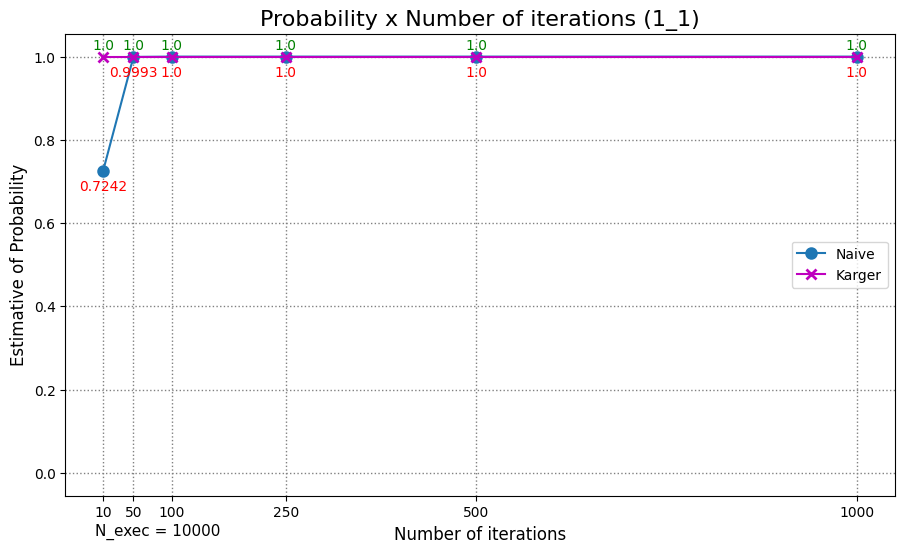

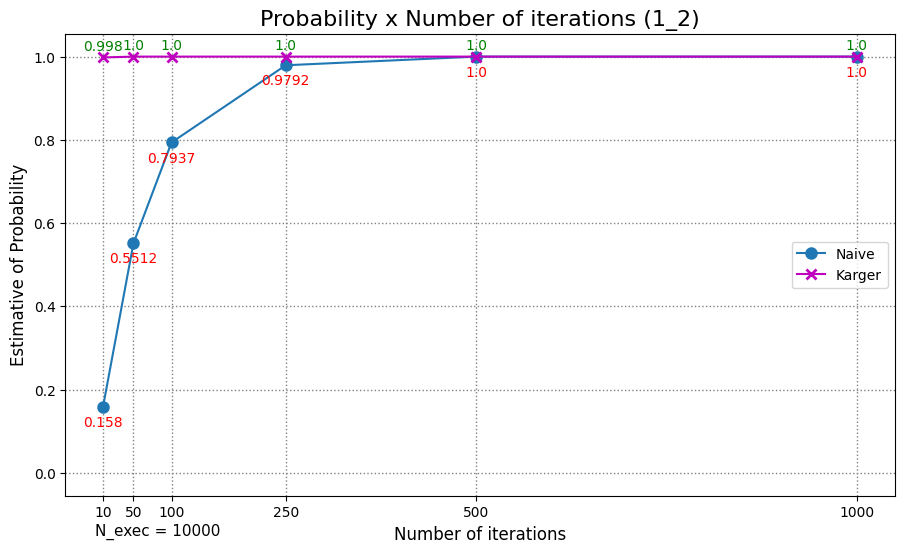

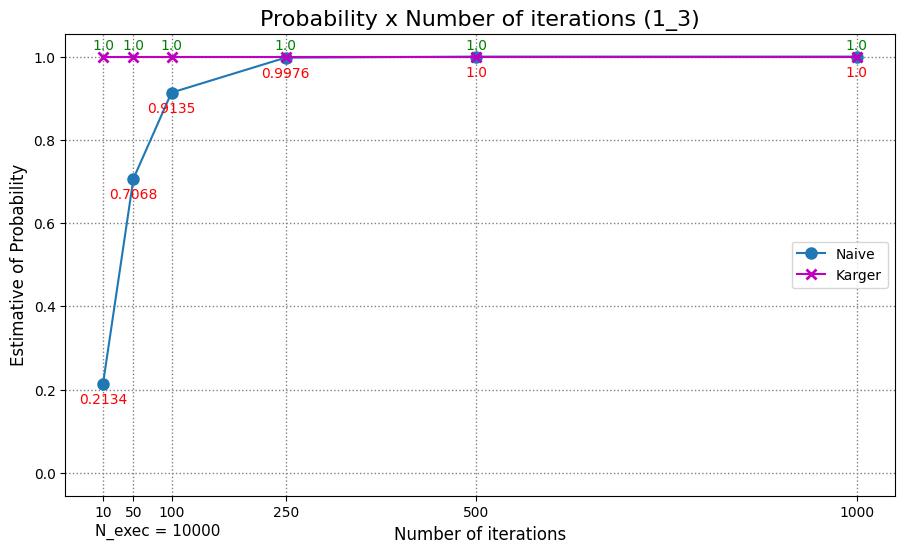

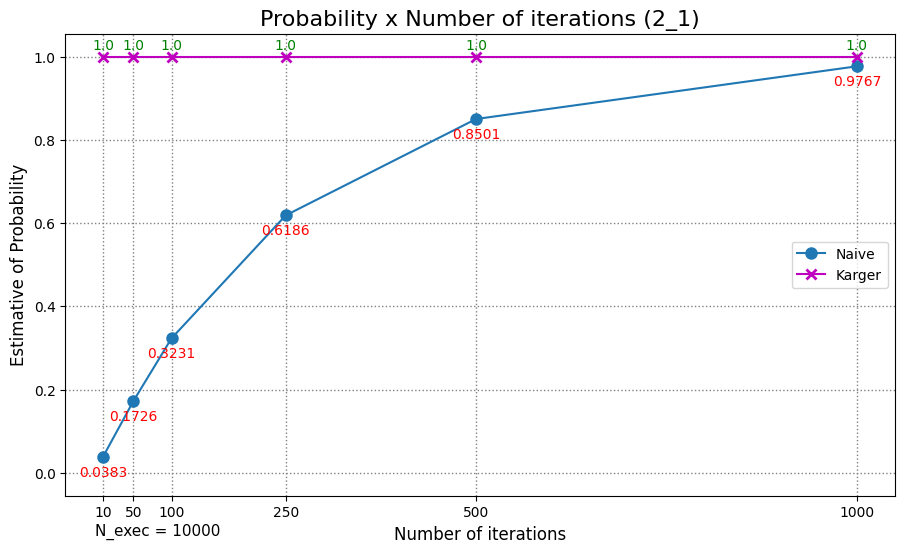

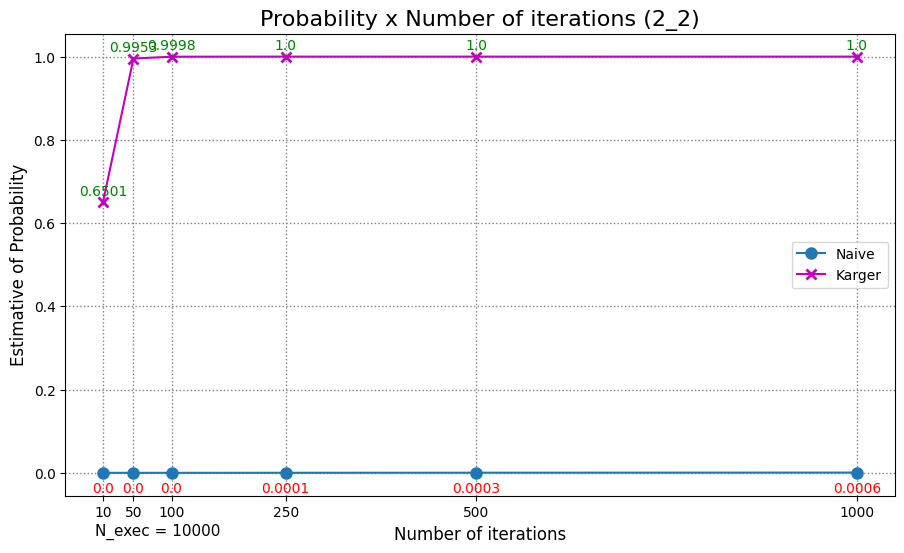

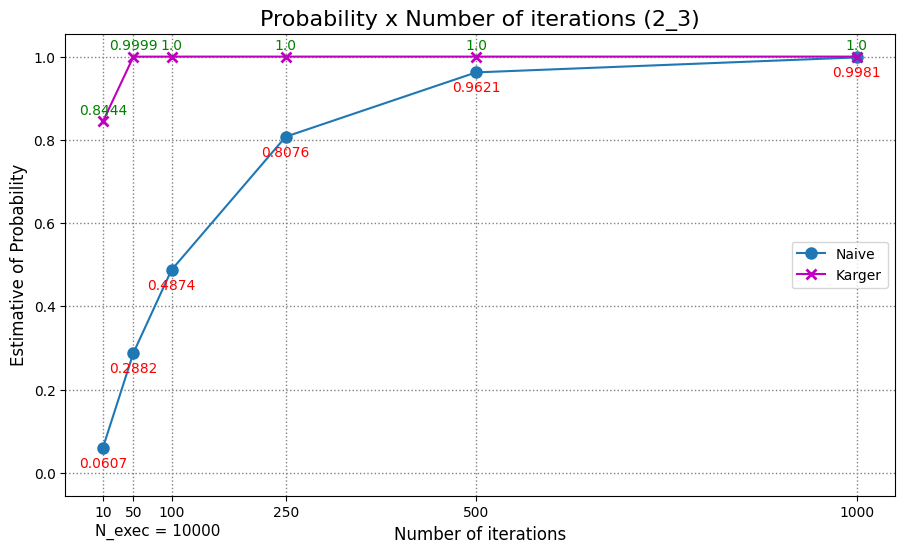

In [133]:
# Getting information up to N_iter=1000, to have a better visualization of the chart
df_report = report.iloc[:72, ]
x_range = [10, 50, 100, 250, 500, 1000]
instances = ['1_1', '1_2', '1_3', '2_1', '2_2', '2_3']

for instance in instances:
    plt.figure(figsize=(10.7, 6))
    plt.rc('grid', linestyle=':', color='gray', linewidth=1)
    plt.grid()
    
    x_naive = df_report[(df_report['Algorithm'] == 'Naive') & (df_report['Instance'] == instance)]['N_iter']
    y_naive = df_report[(df_report['Algorithm'] == 'Naive') & (df_report['Instance'] == instance)]['Prob']
    plt.plot(x_naive, y_naive, label='Naive', marker='o', markeredgewidth=2, markersize=7)
    
    x_karger = df_report[(df_report['Algorithm'] == 'Karger') & (df_report['Instance'] == instance)]['N_iter']
    y_karger = df_report[(df_report['Algorithm'] == 'Karger') & (df_report['Instance'] == instance)]['Prob']
    plt.plot(x_karger, y_karger, label='Karger', marker='x', color='m', markeredgewidth=2, markersize=7)
    
    plt.xlabel('Number of iterations', fontsize=12)
    plt.ylabel('Estimative of Probability', fontsize=12)
    plt.title(f'Probability x Number of iterations ({instance})', fontsize=16)
    plt.xticks(x_range)
    plt.ylim([-0.055, 1.055])
    plt.legend(loc='center right')
    
    
    for x, y in zip(x_naive, y_naive):
        plt.annotate(y, (x, y), textcoords='offset points', xytext=(0, -14), ha='center', color='red', fontsize=10)
        
    for x, y in zip(x_karger, y_karger):
        plt.annotate(y, (x, y), textcoords='offset points', xytext=(0, 5), ha='center', color='green', fontsize=10)
        
    plt.text(-.5, -.15, 'N_exec = 10000', fontsize=11)
    
    plt.show()
    print("\n")

After that we can see that even with 10,000 executions, sometimes, the Naive Algorithm go to nowhere (Instance 2_2) and can see that Karger's Algorithm works with a good performance with a low number of iterations.